# Assignment 3 Advanced programming

Script to analyse molecule ALDL1 inhibition.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from rdkit.Chem import PandasTools, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import pipeline as pl
from sklearn import preprocessing as pp
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
#import graphviz 

# 1 Load tested molecules

We received two files with tested molecules for ALDH1 inhibition. Analysis showed that the prediction algorithms worked with sensitivity, specifity and precision when only the v2 dataset was used! The first dataset showed mediocre results. We decided, though tempting to use only v2, to uses both sets for the predictions, since we don't have any guarantee that the unknown molecules behave more like v2-molecules.

In [5]:
tested_molecules_files = ['tested_molecules.csv','tested_molecules_v2.csv']
dataset_molecules = pd.DataFrame()
for i, file in enumerate(tested_molecules_files):
    tested_molecules = pd.read_csv(os.path.join(os.getcwd(), file))
    PandasTools.AddMoleculeColumnToFrame(tested_molecules, smilesCol='SMILES')
    tested_molecules['FROM DATASET'] = i
    dataset_molecules = dataset_molecules.append(tested_molecules, ignore_index = True)
    
dataset_molecules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SMILES            2000 non-null   object
 1   ALDH1_inhibition  2000 non-null   int64 
 2   ROMol             2000 non-null   object
 3   FROM DATASET      2000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 62.6+ KB


# 2 Preparation of molecular descriptors

Add all molecular descriptor and calculate them to a pd DataFrame dataset_descriptors

In [6]:
descriptors_labels = [n[0] for n in Descriptors._descList[:]]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_labels)
rdkit_desc = [calc.CalcDescriptors(m) for m in dataset_molecules["ROMol"]]
dataset_descriptors = pd.DataFrame(rdkit_desc, columns=[descriptors_labels])

Select only the 'good' descriptors, as calculated by MART........

In [7]:
dataset_descriptors = dataset_descriptors[['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRLOW',
 'SMR_VSA1',
 'SMR_VSA5',
 'SlogP_VSA2',
 'EState_VSA10',
 'VSA_EState2',
 'FractionCSP3',
 'NumAliphaticRings']]

dataset_descriptors.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPLOW,BCUT2D_MRLOW,SMR_VSA1,SMR_VSA5,SlogP_VSA2,EState_VSA10,VSA_EState2,FractionCSP3,NumAliphaticRings
0,13.083531,0.001173,-0.683140,2.277377,-2.329164,-2.524368,-0.128181,14.325937,38.269884,64.304606,9.589074,26.972964,0.375000,1
1,12.170097,0.066966,-0.066966,2.140429,-2.083839,-2.240774,-0.118316,9.211688,18.245949,26.195090,4.794537,21.295170,0.150000,0
2,10.905837,0.016881,-0.016881,2.359046,-2.317898,-3.124535,-0.951912,19.160451,58.848175,49.553366,5.106527,5.789600,0.461538,1
3,11.562446,0.270607,-0.454447,2.116608,-2.205938,-2.211289,0.556316,4.417151,13.847474,13.089513,4.794537,13.738424,0.307692,0
4,12.108866,0.086947,-3.251317,2.259832,-2.158781,-2.269383,-0.115075,13.212334,12.841643,32.109481,13.212334,17.622350,0.222222,1


# 3 Do the tick on the known molecules

### Divide the known dataset in test and train

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset_descriptors, dataset_molecules['ALDH1_inhibition'], test_size=0.2, random_state=42)

### Introducing a Pipeline with minmax scaler and Desciscion tree.

In [9]:
scaler = pp.MinMaxScaler()
pca = PCA()
dtree = tree.DecisionTreeClassifier(max_features=None, max_depth=None, max_leaf_nodes=None)

pipeline = pl.Pipeline(steps=[("sc", scaler), ("pca", pca), ("dtreeCLF", dtree)])
cross_score = cross_val_score(pipeline, X_train, y_train, cv=10)
print("Cross score:") 
print(cross_score)
pipeline.fit(X_train, y_train)
print("score:")
print(pipeline.score(X_test, y_test))

Cross score:
[0.71875 0.725   0.625   0.65    0.6875  0.75625 0.6625  0.65625 0.73125
 0.65625]
score:
0.6875


### Creating a physical tree

In [10]:
#dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=dataset_descriptors.columns, class_names=['1', '0'])
#graph = graphviz.Source(dot_data) 
#graph.render("descision_tree") 

### Analysing the model

In [11]:
y_true = y_test
y_pred = pipeline.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/(tp+fp) 
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(" |+\t|-\t|\n+|{:.0f}\t|{:.0f}\t|\n-|{:.0f}\t|{:.0f}\t|".format(tp, fp, fn, tn))
print("Specificiteit: {:.2f} Sensitivity: {:.2f} Accuracy {:.2f}".format(specificity, sensitivity, accuracy))

 |+	|-	|
+|64	|69	|
-|56	|211	|
Specificiteit: 0.75 Sensitivity: 0.48 Accuracy 0.69


## Further processing of the selection

Create new datafame 'pipeline_results' from X_test. Append values for 'ALDH1_inhibition' and 'predicted'

In [12]:
pipeline_results = X_test.copy()
pipeline_results['ALDH1_inhibition'] = y_test
pipeline_results['predicted'] = y_pred
pipeline_results.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPLOW,BCUT2D_MRLOW,SMR_VSA1,SMR_VSA5,SlogP_VSA2,EState_VSA10,VSA_EState2,FractionCSP3,NumAliphaticRings,ALDH1_inhibition,predicted
1860,12.385892,0.102195,-0.355352,2.096880,-1.996819,-2.138386,0.104208,9.531400,0.000000,19.940714,9.589074,24.733259,0.111111,0,1,0
353,11.497306,0.128372,0.128372,2.026738,-2.066822,-1.978741,0.098787,9.531400,19.951441,5.783245,4.794537,11.497306,0.176471,0,0,0
1333,5.466786,0.512673,0.512673,2.012194,-1.952063,-1.809817,1.016058,0.000000,10.092509,15.181342,0.000000,4.031510,0.125000,0,0,0
905,5.491585,0.749635,0.749635,2.164873,-2.281741,-3.037219,-0.872227,9.636773,6.544756,50.366578,0.000000,12.771802,0.333333,1,0,0
1289,12.326886,0.320137,-4.318778,2.293728,-2.081858,-2.051431,-0.137118,13.171245,12.721055,9.586925,13.171245,0.000000,0.200000,0,0,0


Select only the predicted positives

In [13]:
pipeline_positives = pipeline_results[pipeline_results['predicted'].values == 1]
print("Result: {} positives were selected from pipeline".format(pipeline_positives.shape[0]))

Result: 133 positives were selected from pipeline


In [14]:
type(pipeline_positives)

pandas.core.frame.DataFrame

## Further Selection with Tanamoto similarity

Load all known molecules in frame.

In [15]:
from rdkit import DataStructs
tested_molecules = dataset_molecules.copy()
PandasTools.AddMoleculeColumnToFrame(tested_molecules, smilesCol='SMILES')

Divide molecules in Inhibitors and non-Inhibitors

In [16]:
tested_molecules_pos = tested_molecules[tested_molecules['ALDH1_inhibition'] == 1]
tested_molecules_neg = tested_molecules[tested_molecules['ALDH1_inhibition'] == 0]
print("{}% inhibitors present in known molecules".format(100*len(tested_molecules_pos)/len(tested_molecules)))

30.0% inhibitors present in known molecules


Convert both sets to Morgan Fingerprints (to compare with)

In [17]:
from rdkit.Chem import AllChem
bulk_pos = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in tested_molecules_pos['ROMol']]
bulk_neg = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in tested_molecules_neg['ROMol']]
len_pos = len(bulk_pos); len_neg = len(bulk_neg)

Get indices from pipeline prediction and select these indices from dataset_molecules.
This must be done to retreive SMILES again, since these are needed for the comparison in the for loop

In [18]:
index_pipeline_positives = pipeline_positives.index
pipeline_positives_mol = dataset_molecules.iloc[index_pipeline_positives]
print("{} possible inhibitors were seclected from pipeline".format(len(pipeline_positives_mol)))

133 possible inhibitors were seclected from pipeline


Calculate similarity with tested positives/negatives for every mol from pipeline_positives. Add the similarity to columns.

In [19]:
pipeline_positives_mol_copy = pipeline_positives_mol.copy(deep=False)
# Loop all rows from test set
for index, row in pipeline_positives_mol.iterrows():     
    test_smiles = row['SMILES']
    # Make allchem MolFrom the SMILES and convert it into to GetMorganFingerprintAsBitVec
    test_mol = AllChem.MolFromSmiles(test_smiles)
    ref_fps = AllChem.GetMorganFingerprintAsBitVect(test_mol,2)
    # Calculate similarities with positives and negative
    similarity_pos = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_pos]
    similarity_neg = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_neg]
    # Add all positive and negative similarities and normalize
    rel_sum_pos = sum(similarity_pos)/len_pos # divide by sizes to normalize the result
    rel_sum_neg = sum(similarity_neg)/len_neg # divide by sizes to normalize the result
    
    pipeline_positives_mol_copy.loc[index, ['SIM_WITH_POSITIVE_SET']] = rel_sum_pos
    pipeline_positives_mol_copy.loc[index, ['SIM_WITH_NEGATIVE_SET']] = rel_sum_neg   

pipeline_positives_mol_copy.head()

,SMILES,ALDH1_inhibition,ROMol,FROM DATASET,SIM_WITH_POSITIVE_SET,SIM_WITH_NEGATIVE_SET
938,Cc1nc(O)nc(O)c1CSc1nnc([C@@H](NC(=O)OC(C)(C)C)...,0,<rdkit.Chem.rdchem.Mol object at 0x0000016E6FF...,0,0.092530,0.082123
1731,CC1CCCC(NC(=O)COC(=O)CC2CCCC2)C1C,1,<rdkit.Chem.rdchem.Mol object at 0x0000016E6FF...,1,0.102232,0.055427
65,CC(=O)NC(CC(C)C)C(=O)NC(=O)NCc1ccccc1,1,<rdkit.Chem.rdchem.Mol object at 0x0000016E6FF...,0,0.130870,0.120371
584,COc1ccc(CN2C(=O)/C(=C\Nc3ccc(C)cc3)c3ccccc3C2=...,0,<rdkit.Chem.rdchem.Mol object at 0x0000016E6FF...,0,0.135867,0.118938
674,Cc1cc(C)c(NC(=O)CN2C(=O)NC3(CCOc4ccccc43)C2=O)...,0,<rdkit.Chem.rdchem.Mol object at 0x0000016E6FF...,0,0.145019,0.116876


Since we know the real ALDH1_inibition, we can calculate the number of false positives from the prediction

In [20]:
false_positives = pipeline_positives_mol_copy[pipeline_positives_mol_copy['ALDH1_inhibition'] == 0]
print("{:d} predicted positives from pipeline. {:.1f}% false. ".format(len(pipeline_positives_mol_copy),100*len(false_positives)/len(pipeline_positives_mol_copy)))

133 predicted positives from pipeline. 51.9% false. 


First selection, based on similarity: Only select molecules with larger similarity with positives than with negatives

In [21]:
selection = pipeline_positives_mol_copy[pipeline_positives_mol_copy['SIM_WITH_POSITIVE_SET'] > pipeline_positives_mol_copy['SIM_WITH_NEGATIVE_SET']]
false_positives = selection[selection['ALDH1_inhibition']==0]
print("{:d} predicted positives after first selection. {:.1f}% false positive. ".format(len(selection),100*len(false_positives)/len(selection)))

116 predicted positives after first selection. 46.6% false positive. 


Second selection: Sort the selection by similarity with positives and pick the first 100 molecules

In [22]:
selection_copy = selection.copy()
selection_copy = selection_copy.sort_values(by=['SIM_WITH_POSITIVE_SET'], ascending=False);
selection_copy = selection_copy.iloc[0:100]
false_positives = selection_copy[selection_copy['ALDH1_inhibition']==0]
print("{:d} predicted positives after second selection. {:.1f}% false positive. ".format(len(selection_copy),100*len(false_positives)/len(selection_copy)))

100 predicted positives after second selection. 44.0% false positive. 


# 4 Do the trick on unknown molecules

Load all untested molecules

In [23]:
unknown_molecules = pd.read_csv(os.path.join(os.getcwd(), "untested_molecules.csv"))
PandasTools.AddMoleculeColumnToFrame(unknown_molecules, smilesCol='SMILES')
unknown_molecules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  10000 non-null  object
 1   ROMol   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


Add all molecular descriptor and calculate them to a pd DataFrame dataset_descriptors.
This time we only used the selected labels to avoid long computational time.

In [24]:
#descriptors_labels = [n[0] for n in Descriptors._descList[:]]
good_descriptors_labels = ['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRLOW',
 'SMR_VSA1',
 'SMR_VSA5',
 'SlogP_VSA2',
 'EState_VSA10',
 'VSA_EState2',
 'FractionCSP3',
 'NumAliphaticRings']

In [25]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator(good_descriptors_labels)
rdkit_desc_unknown_molecules = [calc.CalcDescriptors(m) for m in unknown_molecules["ROMol"]]
dataset_descriptors_unknown_molecules = pd.DataFrame(rdkit_desc_unknown_molecules, columns=[good_descriptors_labels])

Instantiate test(unknown molecules) and train(known molecules) set

In [26]:
X_train = dataset_descriptors
y_train = dataset_molecules['ALDH1_inhibition']
X_test = dataset_descriptors_unknown_molecules
r = X_test.shape[0]*[0]
y_test = pd.Series(r, copy=False)

### Introducing a Pipeline with minmax scaler and Desciscion tree.

In [27]:
scaler = pp.MinMaxScaler()
pca = PCA()
dtree = tree.DecisionTreeClassifier(max_features=None, max_depth=None, max_leaf_nodes=None)

pipeline = pl.Pipeline(steps=[("sc", scaler), ("pca", pca), ("dtreeCLF", dtree)])
cross_score = cross_val_score(pipeline, X_train, y_train, cv=10)
print("Cross score:") 
print(cross_score)
pipeline.fit(X_train, y_train)
print("score:")
print(pipeline.score(X_test, y_test))

Cross score:
[0.56  0.6   0.53  0.54  0.575 0.71  0.8   0.85  0.865 0.81 ]
score:
0.6012


### Creating a physical tree

In [28]:
#dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=dataset_descriptors.columns, class_names=['1', '0'])
#graph = graphviz.Source(dot_data) 
#graph.render("descision_tree") 

### Prediction

In [29]:
y_true = y_test
y_pred = pipeline.predict(X_test)

 |+	|-	|
+|0	|3988	|
-|0	|6012	|
Specificiteit: 0.60 Sensitivity: 0.00 Accuracy 0.60


This code calculates further on X_test
A selection of 100 molecules is made, based on the selection from pipeline + further reduction by similarity analysis of the selected molecules with the known ALDH1-positives (and negatives)
Can be appended to Constantijns pipeline.
Als er problemen zijn laat maar weten.

## Further processing of the selection

Create new datafame from X_test. Append values for 'ALDH1_inhibition' and 'predicted'

In [31]:
pipeline_results = X_test.copy()
pipeline_results['predicted'] = y_pred
pipeline_results.head()
pipeline_results[pipeline_results['predicted'].values != 0]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPLOW,BCUT2D_MRLOW,SMR_VSA1,SMR_VSA5,SlogP_VSA2,EState_VSA10,VSA_EState2,FractionCSP3,NumAliphaticRings,predicted
0,12.089288,0.112255,-0.251126,2.080331,-2.078497,-2.257675,-0.126034,9.589074,51.993423,17.526044,9.589074,24.017196,0.347826,0,1
1,12.797328,0.238255,-3.572690,2.332267,-2.298232,-2.409391,-0.152691,22.743734,31.081686,50.840649,18.006871,26.898653,0.391304,2,1
2,12.973159,0.116476,-0.893827,2.418534,-2.162707,-2.347503,-0.383654,23.639663,12.462662,29.889309,24.093808,36.375093,0.176471,1,1
3,11.709157,0.004405,-0.628881,2.099290,-2.057211,-2.757900,-0.724720,24.448012,20.268296,23.335118,14.908855,26.672699,0.222222,0,1
4,12.580327,0.039856,-4.469682,2.318223,-2.297318,-2.329215,-0.137383,17.965782,19.017942,23.980671,17.965782,16.768607,0.384615,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,12.079166,0.093121,-0.525435,2.180273,-2.102721,-2.151036,-0.385361,14.454711,19.003911,33.661099,14.908855,30.804356,0.266667,0,1
9983,12.286560,0.009186,-3.746215,2.399575,-2.149621,-2.333638,0.085681,17.949197,4.895483,31.781831,13.212334,12.210482,0.133333,1,1
9989,12.630514,0.094743,-0.536427,2.143757,-2.067855,-2.256240,-0.145277,9.531400,19.696395,30.514253,9.589074,28.970823,0.150000,0,1
9991,12.705510,0.134945,-0.334667,2.273012,-2.338748,-2.503361,0.056719,23.799663,6.923737,68.805742,9.589074,27.706440,0.500000,1,1


Select only the predicted positives

In [32]:
pipeline_positives = pipeline_results[pipeline_results['predicted'].values == 1]
print("{} positives from pipeline".format(pipeline_positives.shape[0]))

3988 positives from pipeline


## Further Selection with Tanamoto similarity

Load all known molecules in frame. Now for the whole set of molecules

In [34]:
from rdkit import DataStructs
tested_molecules = dataset_molecules.copy()
PandasTools.AddMoleculeColumnToFrame(tested_molecules, smilesCol='SMILES')

Divide molecules in Inhibitors and non-Inhibitors

In [35]:
tested_molecules_pos = tested_molecules[tested_molecules['ALDH1_inhibition'] == 1]
tested_molecules_neg = tested_molecules[tested_molecules['ALDH1_inhibition'] == 0]
print("{}% inhibitors present in known molecules".format(100*len(tested_molecules_pos)/len(tested_molecules)))

30.0% inhibitors present in known molecules


Convert both sets to Morgan Fingerprints (to compare with)

In [36]:
from rdkit.Chem import AllChem
bulk_pos = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in tested_molecules_pos['ROMol']]
bulk_neg = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in tested_molecules_neg['ROMol']]
len_pos = len(bulk_pos); len_neg = len(bulk_neg)

Get indices from pipeline prediction and select these indices from dataset_molecules.
This must be done to retreive SMILES again, since these are needed for the comparison in the for loop

In [37]:
index_pipeline_positives = pipeline_positives.index
pipeline_positives_mol = unknown_molecules.iloc[index_pipeline_positives]
print("{} positive molecules from pipeline".format(len(pipeline_positives_mol)))

3988 positive molecules from pipeline


Calculate similarity with tested positives/negatives for every mol from pipeline_positives

In [38]:
pipeline_positives_mol_copy = pipeline_positives_mol.copy(deep=False)
# Loop all rows from test set
for index, row in pipeline_positives_mol.iterrows():     
    test_smiles = row['SMILES']
    # Make allchem MolFrom the SMILES and convert it into to GetMorganFingerprintAsBitVec
    test_mol = AllChem.MolFromSmiles(test_smiles)
    ref_fps = AllChem.GetMorganFingerprintAsBitVect(test_mol,2)
    # Calculate similarities with positives and negative
    similarity_pos = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_pos]
    similarity_neg = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_neg]
    # Add all positive and negative similarities and normalize
    rel_sum_pos = sum(similarity_pos)/len_pos # divide by sizes to normalize the result
    rel_sum_neg = sum(similarity_neg)/len_neg # divide by sizes to normalize the result
    
    pipeline_positives_mol_copy.loc[index, ['SIM_WITH_POSITIVE_SET']] = rel_sum_pos
    pipeline_positives_mol_copy.loc[index, ['SIM_WITH_NEGATIVE_SET']] = rel_sum_neg   

pipeline_positives_mol_copy.head()

3988 predicted positives from pipeline


Only select molecules with larger similarity with positives than with negatives

In [39]:
selection = pipeline_positives_mol_copy[pipeline_positives_mol_copy['SIM_WITH_POSITIVE_SET'] > pipeline_positives_mol_copy['SIM_WITH_NEGATIVE_SET']]
print("{:d} predicted positives after first selection".format(len(selection)))

3603 predicted positives after first selection


Sort the selection by similarity with positives and pick the first 100 molecules

In [40]:
selection_copy = selection.copy()
selection_copy = selection_copy.sort_values(by=['SIM_WITH_POSITIVE_SET'], ascending=False);
selection_copy = selection_copy.iloc[0:100]
print("{:d} predicted positives after first selection".format(len(selection_copy)))

100 predicted positives after first selection


In [41]:
definite_selection = selection_copy
definite_selection.index

Int64Index([8739, 7410,  330, 8995, 2752, 2482, 1352, 3439, 5687, 8092, 5610,
             195, 6962, 9527, 7024, 5185, 6849, 1038, 3568, 8700, 3523, 6121,
            8922, 7404,  108, 1601,  393, 8483, 2983, 6400, 7729, 6633, 5288,
            4269, 7229, 8192, 4212, 2126, 7844, 5993, 8146, 1483, 6583, 9394,
            6723, 8079, 8006, 5002, 3504, 4610, 5684, 7275, 6701,  854, 6358,
            2342, 4378, 7634, 5644, 4033, 6507, 5398,  997, 4784, 6564, 4309,
            5238,  594, 4150, 9144, 5169, 4112, 8331, 3195, 2817, 8542, 6978,
            9088, 2317, 3194, 4213, 4303, 9432, 2157, 5318,  265, 2498, 8638,
               8, 9991, 4395, 5303, 2909, 2491, 1826,  746, 2340, 1482, 2510,
             449],
           dtype='int64')

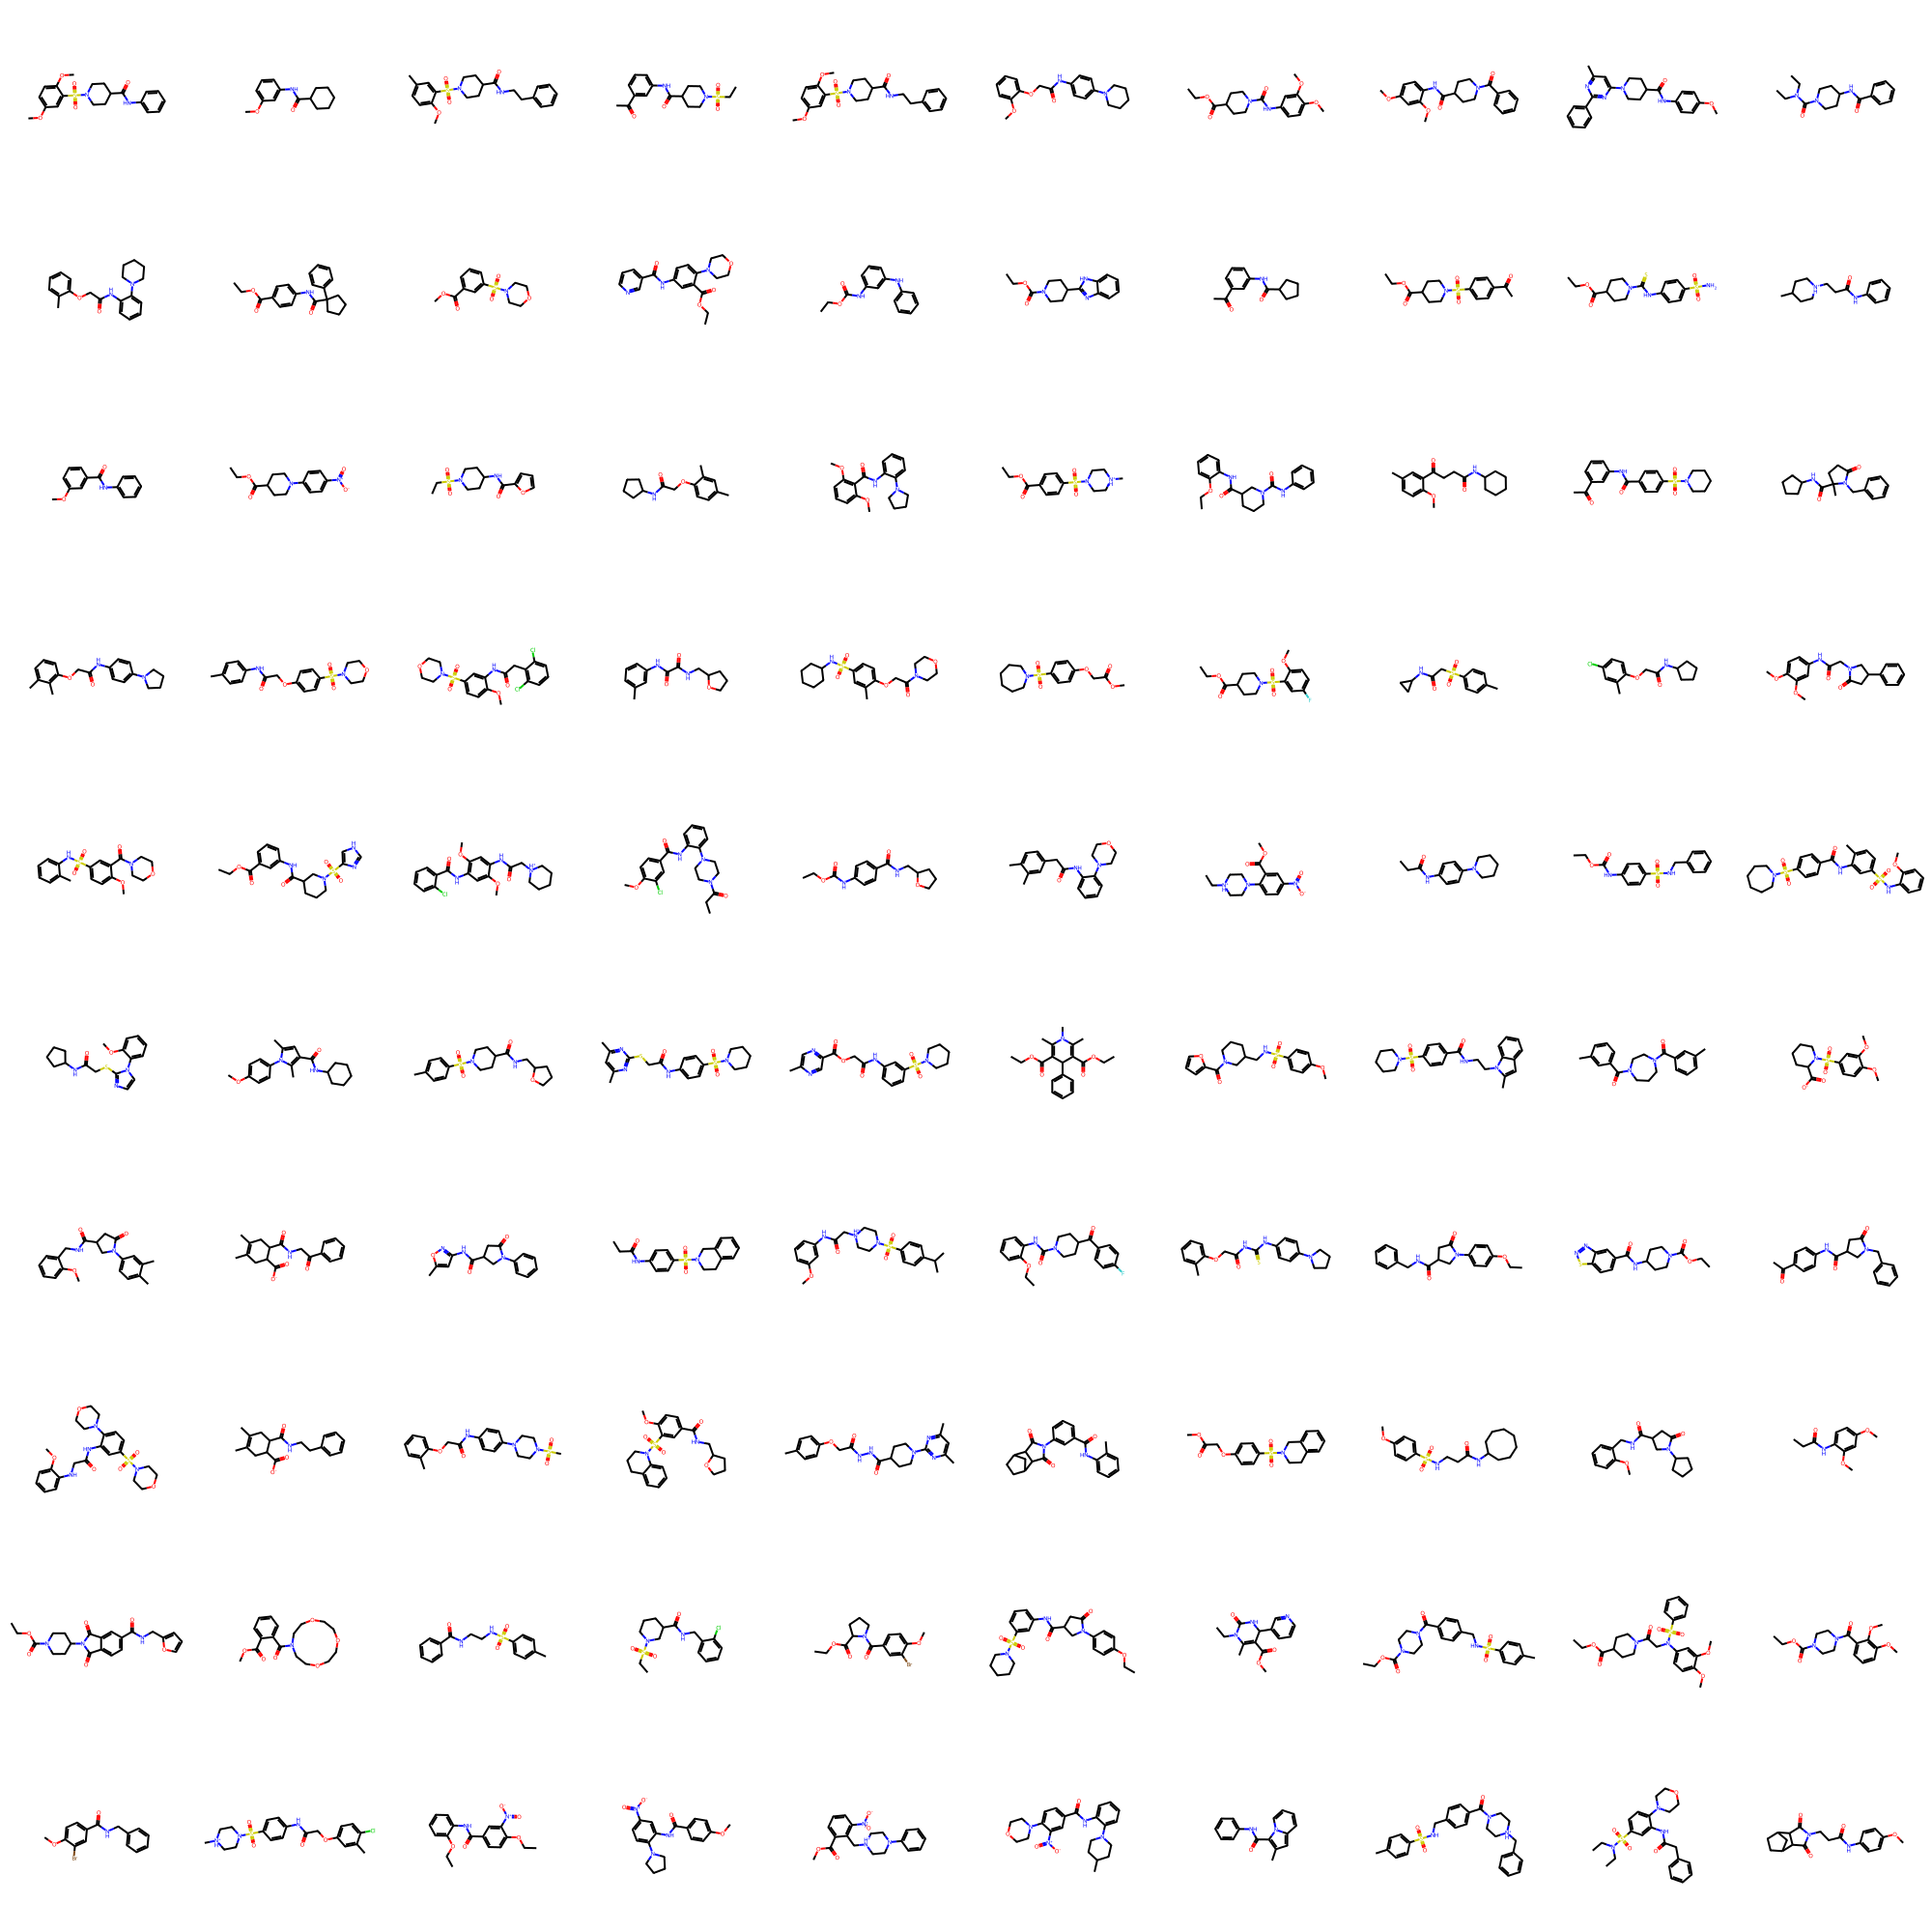

In [42]:
PandasTools.FrameToGridImage(definite_selection, molsPerRow=10, maxMols=100)